In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../../Kaggle/Kaggle 2/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../../Kaggle/Kaggle 2/vegetable-classification-computer-vision.ipynb
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0001.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0002.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0003.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0004.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0005.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0006.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0007.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0008.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0009.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0010.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0011.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0012.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0013.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0014.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0015.jpg
../../Kaggle/Kaggle 2/Vegetable Images\test\Bean\0016.jpg
../

# Problem Statement

<li>VegCart(Random Name) is a fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.</li>

<li>As a starting point, we have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.</li>

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed

In [3]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [4]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()
    
def testAccuracy(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)

def predictions(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
      plt.subplot(num_rows, num_cols, i+1)
      plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("../../Kaggle/Kaggle 2/Models/final_model.h5", save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

In [5]:
set_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [24]:
class_dirs = os.listdir("../../Kaggle/Kaggle 2/Vegetable Images/train") # list all directories inside "train" folder

image_dict = {} # dict to store image array(key) for every class(value)

count_dict = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'../../Kaggle/Kaggle 2/Vegetable Images/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

print("Ya")

Ya


# Exploratory Data Analysis

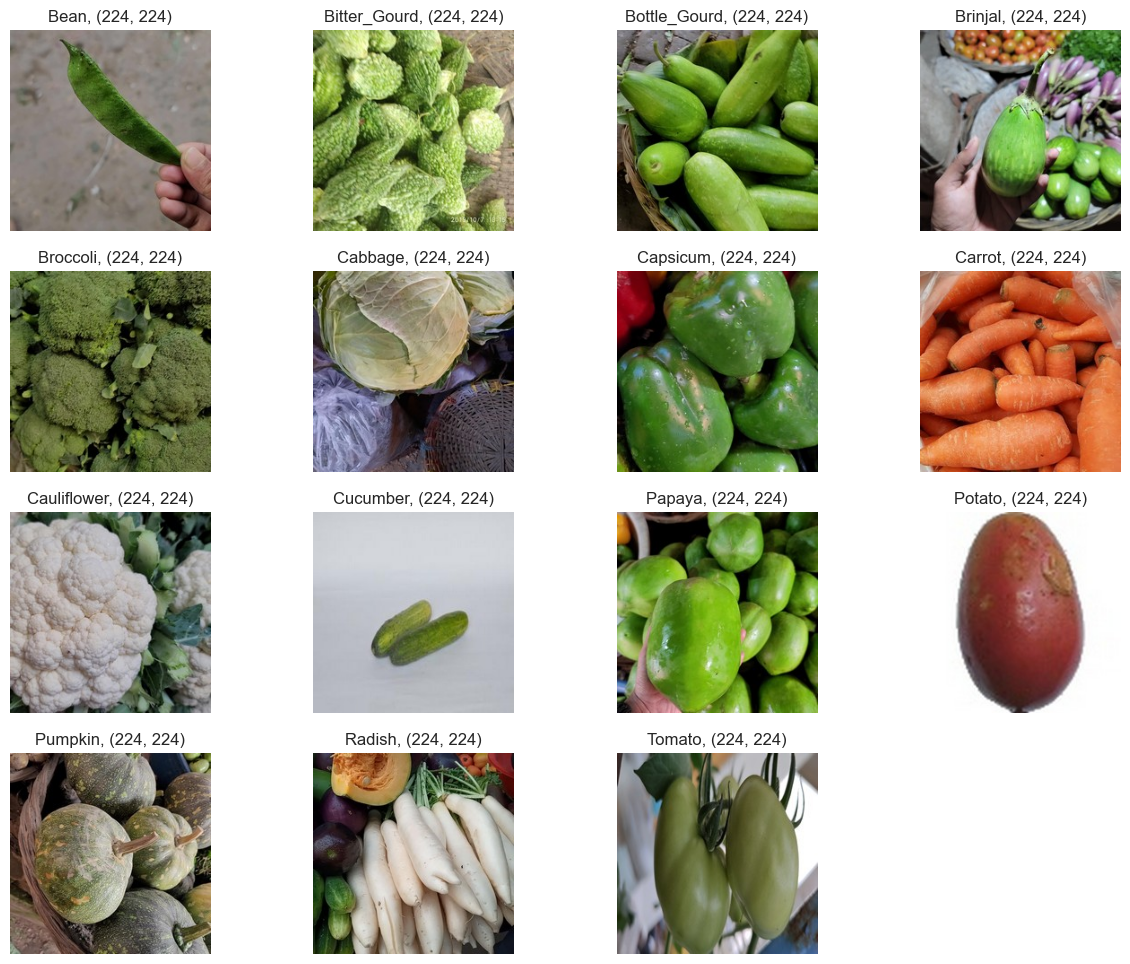

In [7]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [8]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

Count of training samples per class:
            class  count
0           Bean   1000
1   Bitter_Gourd   1000
2   Bottle_Gourd   1000
3        Brinjal   1000
4       Broccoli   1000
5        Cabbage   1000
6       Capsicum   1000
7         Carrot   1000
8    Cauliflower   1000
9       Cucumber   1000
10        Papaya   1000
11        Potato   1000
12       Pumpkin   1000
13        Radish   1000
14        Tomato   1000


<Figure size 1500x1200 with 0 Axes>

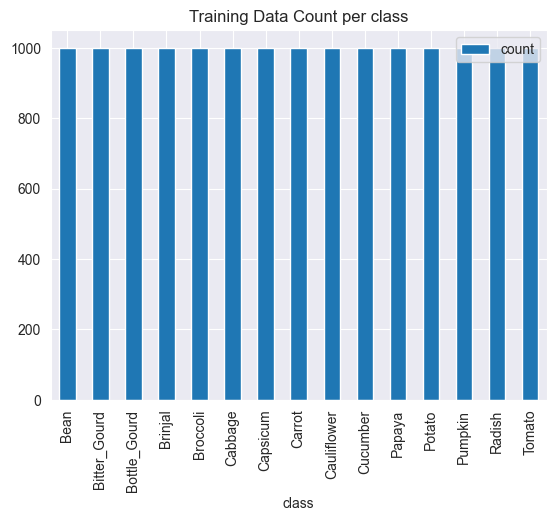

In [9]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class") 
plt.show()

# Loading data set

In [25]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "../../Kaggle/Kaggle 2/Vegetable Images/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "../../Kaggle/Kaggle 2/Vegetable Images/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "../../Kaggle/Kaggle 2/Vegetable Images/test", shuffle = False,
)


Loading Train Data...
Found 15000 files belonging to 15 classes.

Loading Validation Data...
Found 3000 files belonging to 15 classes.

Loading Test Data...
Found 3000 files belonging to 15 classes.


# Data Preprocessing

In [11]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

In [12]:
num_classes = 15
hidden_size_1 = 1024
hidden_size_2 = 256


# Training Simple Neural Network (MLP)

Running a ANN for the given images


In [13]:
model_ann = keras.Sequential(
    name="model_ann",
    layers=[
        layers.Flatten(input_shape=(height, width, 3)),
        layers.Dense(units=hidden_size_1, activation='relu'), # hidden layer 1
        layers.Dense(units=hidden_size_2, activation='relu'), # hidden layer 2
        layers.Dense(units=num_classes, activation='softmax'), # output layer
    ]
)

In [14]:
model_ann.summary()

Model: "model_ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 1024)              154141696 
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 15)                3855      
                                                                 
Total params: 154,407,951
Trainable params: 154,407,951
Non-trainable params: 0
_________________________________________________________________


In [15]:
tf.keras.utils.plot_model(model_ann, to_file="model_ann.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
model_ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
epochs = 25
model_fit = model_ann.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/25
469/469 [==============================] - 224s 476ms/step - loss: 12.0002 - accuracy: 0.2951 - val_loss: 1.7802 - val_accuracy: 0.4610
Epoch 2/25
469/469 [==============================] - 213s 453ms/step - loss: 1.8095 - accuracy: 0.4569 - val_loss: 1.6525 - val_accuracy: 0.5193
Epoch 3/25
469/469 [==============================] - 203s 432ms/step - loss: 1.4445 - accuracy: 0.5421 - val_loss: 1.4568 - val_accuracy: 0.5577
Epoch 4/25
469/469 [==============================] - 200s 426ms/step - loss: 1.3140 - accuracy: 0.5828 - val_loss: 1.3200 - val_accuracy: 0.5693
Epoch 5/25
469/469 [==============================] - 203s 432ms/step - loss: 1.1854 - accuracy: 0.6235 - val_loss: 1.3535 - val_accuracy: 0.5840
Epoch 6/25
469/469 [==============================] - 204s 434ms/step - loss: 1.1491 - accuracy: 0.6355 - val_loss: 1.0555 - val_accuracy: 0.6750
Epoch 7/25
469/469 [==============================] - 200s 426ms/step - loss: 1.0597 - accuracy: 0.6593 - val_loss: 1.3570 

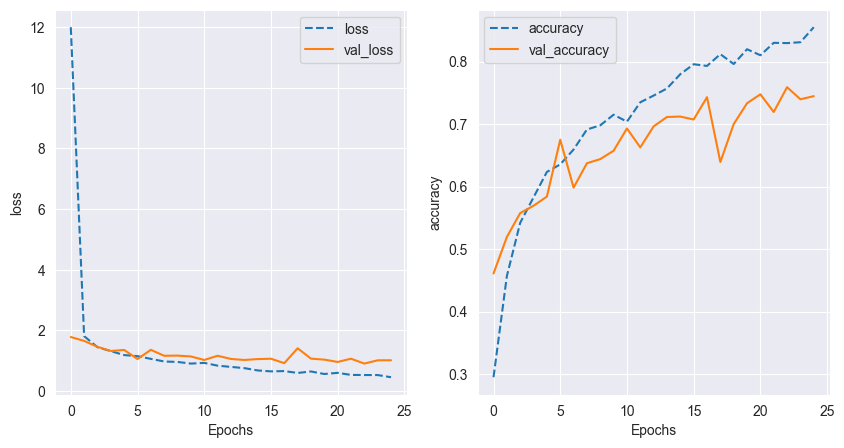

In [23]:
training_plot(['loss', 'accuracy'], model_fit)

In [24]:
testAccuracy(model_ann)

94/94 [==============================] - 13s 127ms/step

Test Accuracy: 75.53%



94/94 [==============================] - 12s 126ms/step


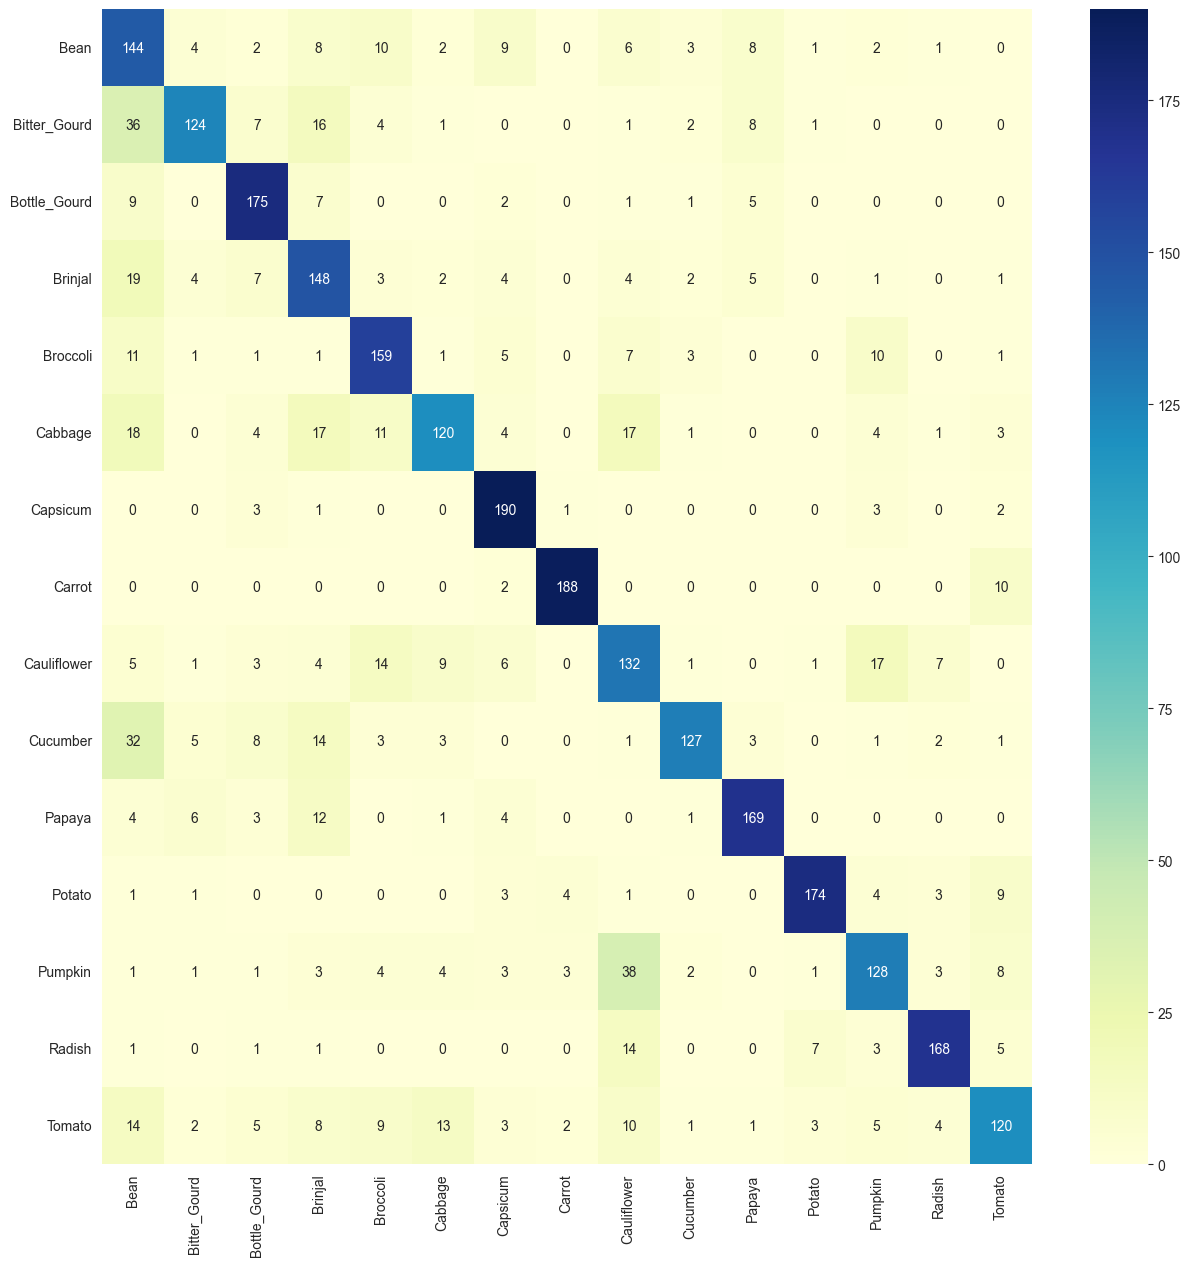

In [25]:
ConfusionMatrix(model_ann, test_ds, test_data.class_names)

# Transfer Learning

## VGG16

In [17]:
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [18]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 15)                975       
                                                                 
Total params: 14,748,495
Trainable params: 33,807
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
vgg16_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
EPOCHS = 50

history_vgg16 = vgg16_model.fit(train_ds, epochs=25, validation_data=val_ds,callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/25
469/469 [==============================] - 1243s 3s/step - loss: 1.1448 - accuracy: 0.7377 - val_loss: 0.4861 - val_accuracy: 0.9023
Epoch 2/25
469/469 [==============================] - 1132s 2s/step - loss: 0.3608 - accuracy: 0.9210 - val_loss: 0.2566 - val_accuracy: 0.9463
Epoch 3/25
469/469 [==============================] - 1111s 2s/step - loss: 0.2118 - accuracy: 0.9545 - val_loss: 0.1797 - val_accuracy: 0.9670
Epoch 4/25
469/469 [==============================] - 1292s 3s/step - loss: 0.1439 - accuracy: 0.9707 - val_loss: 0.1271 - val_accuracy: 0.9740
Epoch 5/25
469/469 [==============================] - 1318s 3s/step - loss: 0.1074 - accuracy: 0.9777 - val_loss: 0.1016 - val_accuracy: 0.9803
Epoch 6/25
469/469 [==============================] - 1306s 3s/step - loss: 0.0856 - accuracy: 0.9825 - val_loss: 0.0875 - val_accuracy: 0.9827
Epoch 7/25
469/469 [==============================] - 1171s 2s/step - loss: 0.0685 - accuracy: 0.9863 - val_loss: 0.0741 - val_accuracy:

KeyboardInterrupt: 

In [22]:
training_plot(['loss', 'accuracy'], history_vgg16)

NameError: name 'history_vgg16' is not defined

In [49]:
testAccuracy(vgg16_model)


Test Accuracy: 99.43%



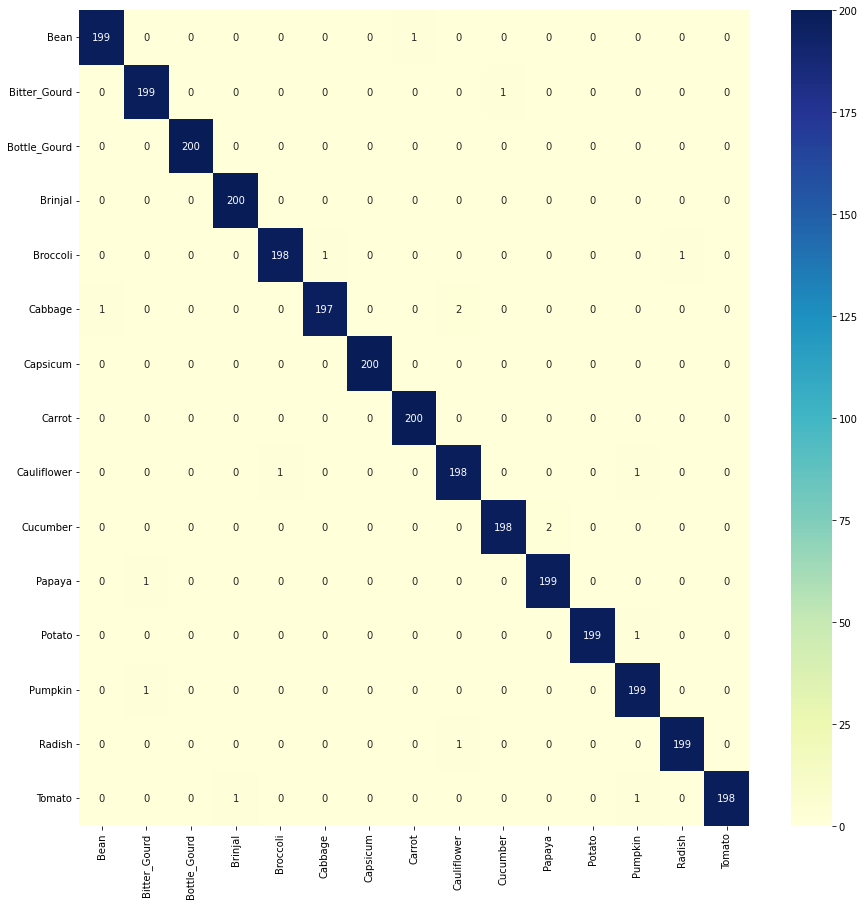

In [50]:
ConfusionMatrix(vgg16_model, test_ds, test_data.class_names)

## Resnet

In [51]:
pretrained_resnet_model = tf.keras.applications.ResNet50V2(weights='imagenet',
                         include_top=False,
                         input_tensor = (tf.keras.layers.Input(shape=(height,width,3)))
                         )
pretrained_resnet_model.trainable=False
resnet_model = tf.keras.Sequential([
    pretrained_resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

94683136/94668760 [==============================] - 1s 0us/step


In [52]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                30735     
Total params: 23,595,535
Trainable params: 30,735
Non-trainable params: 23,564,800
_________________________________________________________________


In [53]:
resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
history_resnet = resnet_model.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/25
469/469 [==============================] - 58s 114ms/step - loss: 0.1615 - accuracy: 0.9601 - val_loss: 0.0314 - val_accuracy: 0.9953
Epoch 2/25
469/469 [==============================] - 53s 112ms/step - loss: 0.0190 - accuracy: 0.9970 - val_loss: 0.0196 - val_accuracy: 0.9957
Epoch 3/25
469/469 [==============================] - 53s 112ms/step - loss: 0.0084 - accuracy: 0.9994 - val_loss: 0.0145 - val_accuracy: 0.9967
Epoch 4/25
469/469 [==============================] - 53s 112ms/step - loss: 0.0046 - accuracy: 0.9999 - val_loss: 0.0121 - val_accuracy: 0.9967
Epoch 5/25
469/469 [==============================] - 52s 111ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.0107 - val_accuracy: 0.9973
Epoch 6/25
469/469 [==============================] - 52s 111ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 0.9980
Epoch 7/25
469/469 [==============================] - 52s 110ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0095 - val_ac

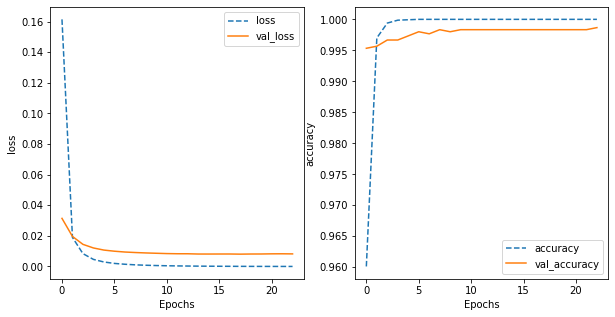

In [55]:
training_plot(['loss', 'accuracy'], history_resnet)

In [56]:
testAccuracy(resnet_model)


Test Accuracy: 99.73%



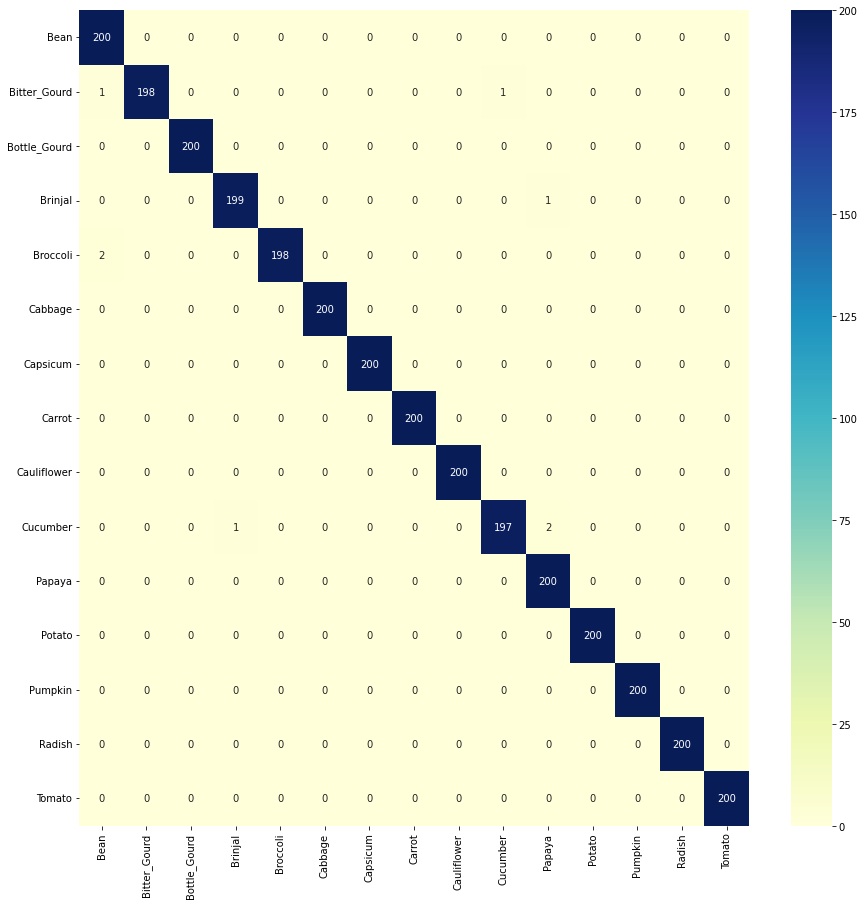

In [57]:
ConfusionMatrix(resnet_model, test_ds, test_data.class_names)

# MobileNet

In [58]:
pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_mobilenet_model.trainable=False
mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

9420800/9406464 [==============================] - 0s 0us/step


In [59]:
mobilenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 15)                19215     
Total params: 2,277,199
Trainable params: 19,215
Non-trainable params: 2,257,984
_________________________________________________________________


In [61]:
history_mobilenet = mobilenet_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/10
469/469 [==============================] - 47s 93ms/step - loss: 0.1947 - accuracy: 0.9587 - val_loss: 0.0368 - val_accuracy: 0.9940
Epoch 2/10
469/469 [==============================] - 43s 90ms/step - loss: 0.0247 - accuracy: 0.9970 - val_loss: 0.0195 - val_accuracy: 0.9967
Epoch 3/10
469/469 [==============================] - 43s 90ms/step - loss: 0.0124 - accuracy: 0.9988 - val_loss: 0.0139 - val_accuracy: 0.9970
Epoch 4/10
469/469 [==============================] - 44s 92ms/step - loss: 0.0073 - accuracy: 0.9995 - val_loss: 0.0110 - val_accuracy: 0.9977
Epoch 5/10
469/469 [==============================] - 42s 89ms/step - loss: 0.0047 - accuracy: 0.9999 - val_loss: 0.0091 - val_accuracy: 0.9980
Epoch 6/10
469/469 [==============================] - 40s 85ms/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.0081 - val_accuracy: 0.9980
Epoch 7/10
469/469 [==============================] - 43s 91ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.0074 - val_accuracy:

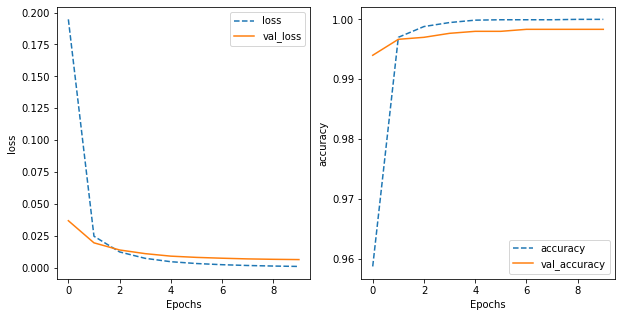

In [62]:
training_plot(['loss', 'accuracy'], history_mobilenet)

In [63]:
testAccuracy(mobilenet_model)


Test Accuracy: 99.90%



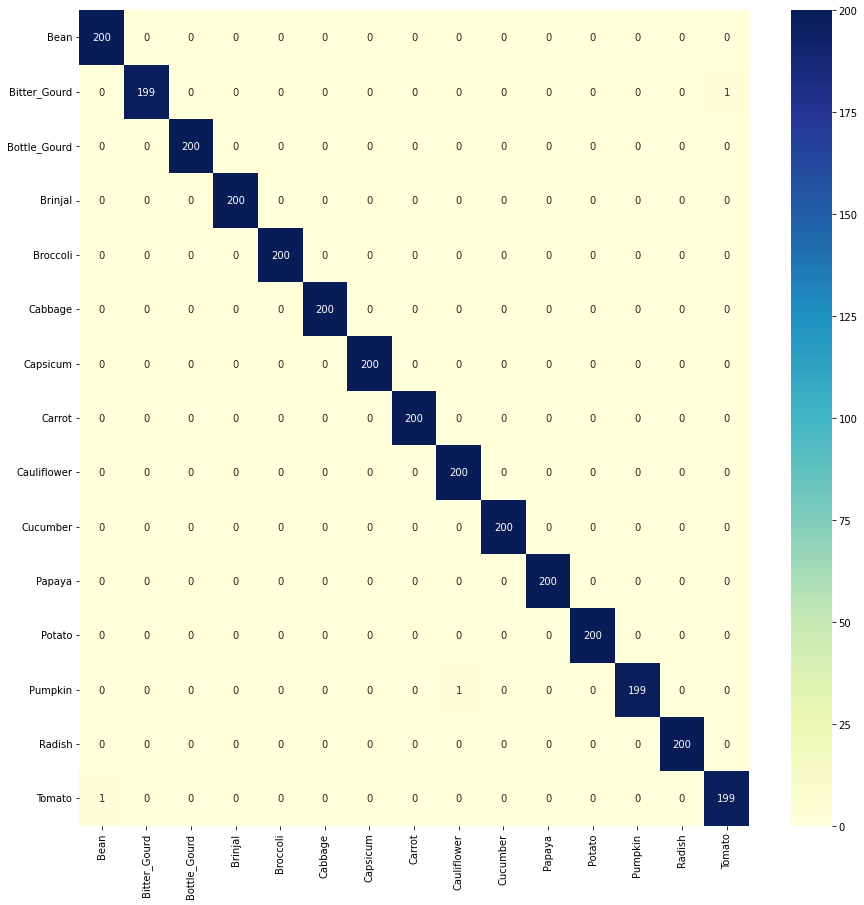

In [64]:
ConfusionMatrix(mobilenet_model, test_ds, test_data.class_names)

# Checking Predictions with the best models -
- ResNet
- MobileNet

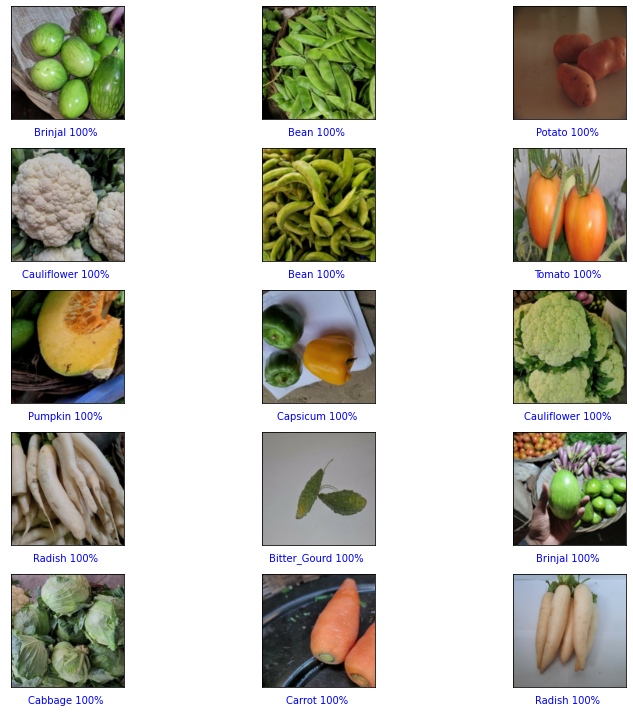

In [65]:
predictions(resnet_model)

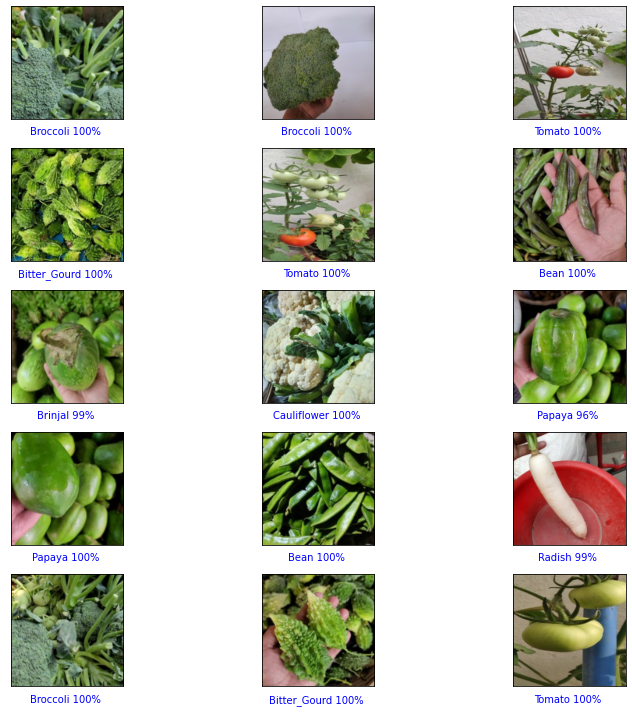

In [66]:
predictions(mobilenet_model)

# Summary
<ul>
  <li>Simple MLP: Being a simple ANN the model is misclassifying the 'Cucumber','Papaya' and 'Cauliflower' and gives a test accuracy of around 75%.</li>
  <li>Baseline Model: The model itself is performing really well with the data set and giving 74% test accuracy.</li>
  <li>Improved Baseline Model: By adding more depth to the model and adding Batchnormalization and Dropout layers with early stopping the model exceptionally well with test accuracy above 90%. </li>
  <li>Transfer Learning: All the models performed really well and test accuracy was exceptionally amazing with simple architecture like Mobilenet and surprisingly well with the naive model like VGG16.</li>
</ul>
